## Federated learning using Keras (averaging weights)

**Status:** PUBLIC Distribution <br>
**File Name:** 02_Federated_learning_MNIST.ipynb

**Author:** Jaume Manero  <br> 
**Date created:** 2023/02/23<br>
**Last modified:** 2023/08/23<br>
**Description:** A simple federated learning program

see package requirements at the end of notebook <br>
Based on https://github.com/SadmanSakib93/Federated-Learning-Keras/blob/main/Fed%20Learning%20-%20FL.ipynb

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import psutil
import csv
from itertools import repeat
from PIL import Image
#from numpy import asarray

In [4]:
# We load the standard dataset and we convert it to 0..1
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

xTrain = xTrain.reshape(60000, 784)
xTest = xTest.reshape(10000, 784)
xTrain = xTrain.astype('float32')
x_test = xTest.astype('float32')
xTrain /= 255
x_test /= 255
print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

# convert class vectors to binary class matrices
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)

60000 train samples
10000 test samples


In [5]:
# Global parameters

verb, epochs, batch_size = 0, 20, 64
numOfIterations = 25
numOfClients  = 5 # do not increase number of clients too much
modelLocation = "./Models/ANN_Sync_users_"+str(numOfClients)+str(numOfIterations)+"_FL_Model.h5"
accList, precList, recallList, f1List = [], [], [], []

In [6]:
# Server-Clients split 
# Train 30% of the data centrally and 70% in clients
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.70,random_state=523) 
xServerTest, xClientsTest, yServerTest, yClientsTest = train_test_split(xTrain, yTrain, 
                                                                        test_size=0.70,random_state=523)
print(xServer.shape, xClients.shape)

(18000, 784) (42000, 784)


In [7]:
def createDeepModel():
   model = Sequential()
   model.add(Dense(16, activation='relu', input_shape=(784,)))
   model.add(Dense(64, activation='relu'))
#   model.add(Dense(64, activation='relu'))
   model.add(Dense(10, activation='softmax'))
   model.summary()
   model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])
   return model

def predictTestData(yPredict, yTest):
    #Converting predictions to label
    print("yPredict",len(yPredict))
    pred = list()
    for i in range(len(yPredict)):
        pred.append(np.argmax(yPredict[i]))
    #Converting one hot encoded test label to label
    test = list()
    for i in range(len(yTest)):
        test.append(np.argmax(yTest[i]))
    return my_metrics(test, pred)

def sumOfWeights(weights):
    return sum(map(sum, weights))

def getWeights(model):
    allLayersWeights=deepModel.get_weights()
    return allLayersWeights

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    recall=recall_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [18]:
# Analysis of accuracy and loss in training phase
def Analyze_training(h):
   f = plt.figure(figsize=(7, 3))
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.subplot(1,2,1)
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
#   plt.ylim(0,1)
   plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
   plt.subplot(1,2,2)
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.ylim(0,1)
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

In [19]:
# Supporting functions
deepModelAggWeights=[]
firstClientFlag=True

def updateServerModel(clientModel, clientModelWeight):
    global firstClientFlag
    for ind in range(len(clientModelWeight)):
        if(firstClientFlag==True):
            deepModelAggWeights.append(clientModelWeight[ind])            
        else:
            deepModelAggWeights[ind]=(deepModelAggWeights[ind]+clientModelWeight[ind])

def updateClientsModels():
    global clientsModelList
    global deepModel
    clientsModelList.clear()
    for clientID in range(numOfClients):
        m = keras.models.clone_model(deepModel)
        m.set_weights(deepModel.get_weights())
        clientsModelList.append(m)
    


In [20]:
# Initially train central deep model
nonFmodel = createDeepModel()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                12560     
                                                                 
 dense_7 (Dense)             (None, 64)                1088      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________


### A. Baseline Centralized Model

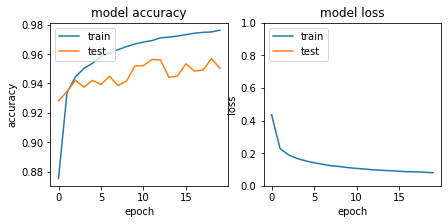

Accuracy  : 0.9504
Precision : 0.9518469384324569
Recall : 0.9504
f1Score : 0.9503199345300616
[[ 970    0    5    2    3    4    9    2    8    7]
 [   0 1095    0    0    0    1    1    0    1    5]
 [   2    6 1008   12   10    4    4   23   12    1]
 [   0   12    7  982    8   40    0   23   30   29]
 [   0    0    1    0  875    1    2    1    1    4]
 [   0    0    0    6    1  819    1    0   10    7]
 [   3    3    4    0   22   15  940    1    9    1]
 [   1    9    3    3    9    2    0  972    3    4]
 [   3   10    4    5    7    4    1    2  897    5]
 [   1    0    0    0   47    2    0    4    3  946]]


(0.9504, 0.9518469384324569, 0.9504, 0.9503199345300616)

In [21]:
# A baseline model non-federated (Train and Test)
h = nonFmodel.fit(xTrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verb,
                    validation_data=(xTest, yTest))
Analyze_training(h)
yhat = nonFmodel.predict(xTest)
y1 = np.argmax(yhat, axis=1)
y2 = np.argmax(yTest, axis=1)
my_metrics(y1,y2)


In [22]:
clientDataInterval=len(xClients)//numOfClients
clientDataInterval=clientDataInterval//numOfIterations
clientDataInterval

336

### Decentralized (Federated Model)

In [31]:
# Server-Clients split 
# Only clients are trained
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.9999,random_state=523) 
xServerTest, xClientsTest, yServerTest, yClientsTest = train_test_split(xTrain, yTrain, 
                                                                        test_size=0.9999,random_state=523)
print(xServer.shape, xClients.shape)

(6, 784) (59994, 784)


In [32]:
# decentralized model
# Only clients train / Server does not train
# Each iteration different data (total_data/number of clients)

print('We have ', numOfClients , 'clients')
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape
for i in range(0, numOfClients):
    print('Data shape on client',i,yClientsList[i].shape)


We have  5 clients
Data shape on client 0 (11998, 10)
Data shape on client 1 (11998, 10)
Data shape on client 2 (11998, 10)
Data shape on client 3 (11998, 10)
Data shape on client 4 (11998, 10)


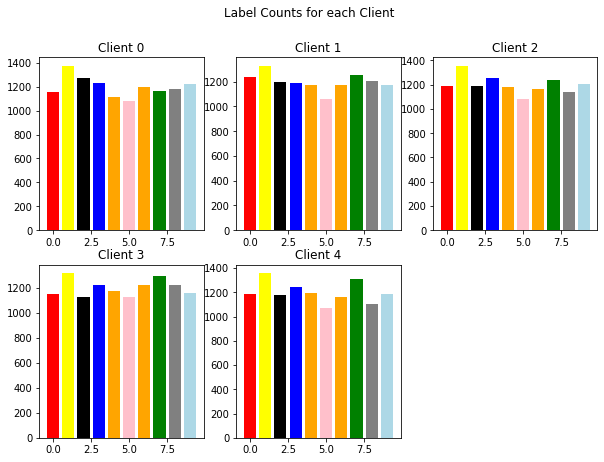

In [33]:
# visually check client distribution of data
# Number of examples per layer for a sample of clients

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']

f = plt.figure(figsize=(10,7))
f.suptitle('Label Counts for each Client')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    f.add_subplot(2,3, i+1)
#    f.add_subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
    
plt.show()   

### B. Training the federated network - Averaging Weights

In [36]:
# Training 
deepModel = createDeepModel()

process = psutil.Process(os.getpid())

for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', 
                                          metrics=['accuracy'])
        
        history = clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], 
                                                 epochs=epochs, 
                                                 batch_size=batch_size, 
                                                 verbose=verb)
#       Analyze_training(history)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
        
    #Average all clients model
    
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score = predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                12560     
                                                                 
 dense_19 (Dense)            (None, 64)                1088      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________
Iteration 1
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4


ValueError: Layer sequential_6 weight shape (784, 16) is not compatible with provided weight shape (784, 8).

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                12560     
                                                                 
 dense_19 (Dense)            (None, 64)                1088      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________


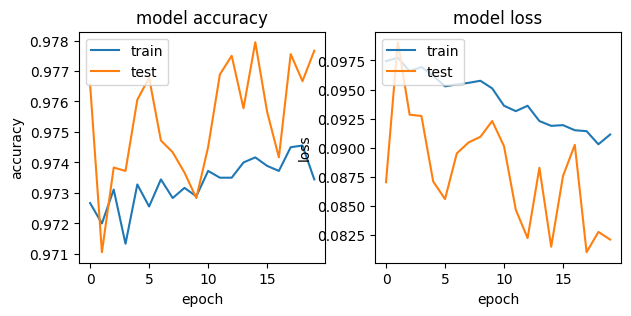

Accuracy  : 0.9133
Precision : 0.9137618094269193
Recall : 0.9133
f1Score : 0.912895550951301
[[ 933    0    6    1    0    7    8    4    4    3]
 [   0 1035    1    0    1    0    3    2    1    0]
 [   4   12  925   17    4    1    7   13    8    0]
 [   0    2   21  905    1   22    1   11   17   18]
 [   1    3    4    0  865    1    7    5    7   17]
 [  10   14    7   52    2  817   21    4   23   18]
 [  20    6   23    5   16   16  899    0   16    0]
 [   3   16   17   10   14    4    0  967    5   36]
 [   8   45   27   14    4   17   12    2  882   12]
 [   1    2    1    6   75    7    0   20   11  905]]


In [41]:
# C Hybrid Model Server and Client 
deepmodel = createDeepModel()
def trainInServer():
    h = deepModel.fit(xServer, yServer, 
                      epochs=epochs, batch_size=batch_size, verbose=verb,
                      validation_data=(xServerTest, yServerTest))
    deepModel.save(modelLocation)
    Analyze_training(h)
    yhat = deepModel.predict(xTest)
    y1 = np.argmax(yhat, axis=1)
    y2 = np.argmax(yTest, axis=1)
    my_metrics(y1,y2)
    
trainInServer()

'./Models/ANN_Sync_users_525_FL_Model.h5'

In [42]:
# ------- 2. Separate clients data into lists ----------
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape

(8400, 10)

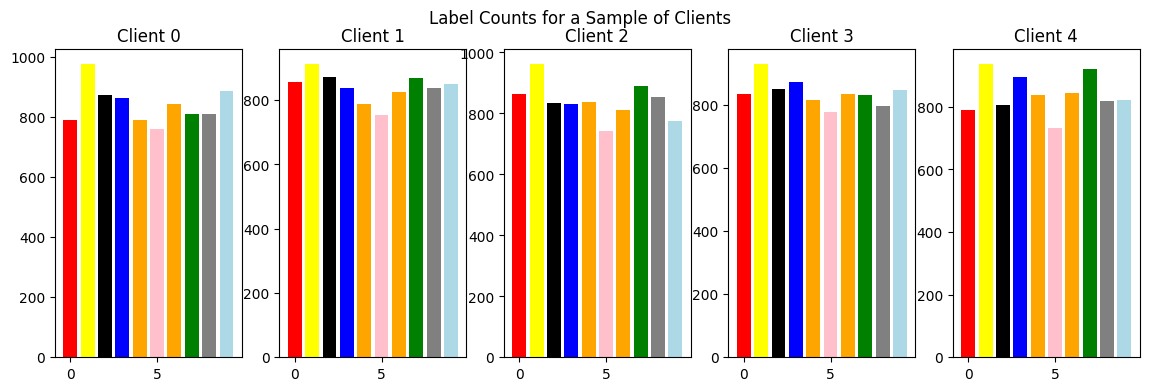

In [45]:
# Number of examples per layer for a sample of clients

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']

f = plt.figure(figsize=(14, 4))
f.suptitle('Label Counts for a Sample of Clients')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    plt.subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
        
       


In [46]:
# ------- 3. Update clients' model with intial server's deep-model ----------

#revisa si estas dos lineas valen
#for clientID in range(numOfClients):
#    clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
start_time = time.time()
process = psutil.Process(os.getpid())
for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', 
                                          metrics=['accuracy'])
        
        history = clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, 
                                                 batch_size=batch_size, verbose=verb)
#       Analyze_training(history)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
        
    #Average all clients model
    
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score = predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)



Iteration 1
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9225
Precision : 0.9251229812634622
Recall : 0.9225
f1Score : 0.9228654694504513
[[946   0   2   1   1   8  11   2   8   1]
 [  0 996  12   3   2  16   5  13  87   1]
 [  9   0 946  22   4   5  14  10  20   2]
 [  2   0  19 936   0  23   2   9  16   3]
 [  0   0   5   1 872   4  14   7   4  75]
 [  6   0   1  33   2 808  11   2  20   9]
 [ 10   3   5   1   7  13 903   0  16   0]
 [  3   2  16   8   3   4   1 968   4  19]
 [  4   1   3  13   6  12   5   4 917   9]
 [  2   1   0  15  11  16   0  21  10 933]]
Acc:
 0.9225
Prec:
 0.9251229812634622
Recall:
 0.9225
F1-Score:
 0.9228654694504513
Iteration 2
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9241
Precision : 0.9261290816806742
Recall : 0.9241
f1Score : 0.9244548900303842
[[ 945    0    2    2    0    9   11    2    9

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9258
Precision : 0.9277862296836673
Recall : 0.9258
f1Score : 0.9261465555890969
[[ 945    0    2    2    0    7    9    3   11    1]
 [   0 1051    6    4    1   16    2   10   44    1]
 [  10    1  930   35    6    6   14   10   17    3]
 [   1    0   14  945    0   23    3    8   13    3]
 [   0    0    4    0  863    6   15    5    3   86]
 [   5    2    2   35    1  812    6    1   17   11]
 [   9    3    6    1    5   19  894    0   21    0]
 [   0    2   14    7    3    5    1  971    3   22]
 [   4    2    4   22    5   16    4    8  901    8]
 [   2    3    0   13   12   16    0   11    6  946]]
Acc:
 0.9258
Prec:
 0.9277862296836673
Recall:
 0.9258
F1-Score:
 0.9261465555890969
Iteration 12
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9267
Precision : 0.9286315867549391
Recall : 0.92

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9257
Precision : 0.9278214369735471
Recall : 0.9257
f1Score : 0.9260090836365742
[[ 947    0    3    3    0    4    9    4    9    1]
 [   0 1070    5    6    1   10    2    8   32    1]
 [   8    3  935   31    7    5   13   10   15    5]
 [   1    1   14  949    0   20    1    7   13    4]
 [   0    0    4    0  848    5   15    6    3  101]
 [   6    2    2   37    1  804    7    1   20   12]
 [  11    3    8    1    5   17  891    0   22    0]
 [   0    2   15   10    1    4    1  964    3   28]
 [   4    3    6   25    4   14    3    8  896   11]
 [   2    2    0   12   10   12    0   10    8  953]]
Acc:
 0.9257
Prec:
 0.9278214369735471
Recall:
 0.9257
F1-Score:
 0.9260090836365742
Iteration 22
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9249
Precision : 0.9271078901475608
Recall : 0.92

---Memory--- 6.500504737017655
--- 717.361406326294 seconds (TRAINING)---


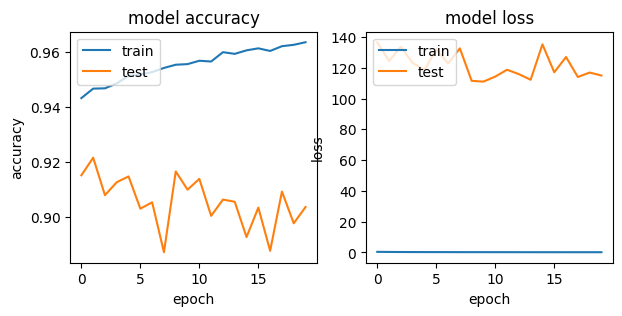

In [49]:
# 3. Evaluation at server

memoryTraining=process.memory_percent()
timeTraining=time.time() - start_time
print("---Memory---",memoryTraining)
print("--- %s seconds (TRAINING)---" % (timeTraining))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=verb, mode='auto')

history = deepModel.fit(xServer, yServer, epochs=epochs, 
                        validation_data = (xTest,yTest), verbose=verb)
                        # callbacks=[early_stopping])

learningAccs = history.history['val_accuracy']
learningLoss = history.history['val_loss']



Analyze_training(history)

In [50]:
# evaluation results
# resultSaveLocation=root_path+'Results/'+algoName+'_Users_vs_TR_vs_Iterations_vs_AccLossMemTime'+'.csv'
dfSave=pd.DataFrame(columns=['Clients', 'Iterations to converge', 'Accuracy', 'Loss', 'Memory', 'Time'])
dfSaveIndex=0
saveList = [numOfClients, len(learningLoss), learningAccs[len(learningAccs)-1], learningLoss[len(learningLoss)-1], memoryTraining, timeTraining]
dfSave.loc[dfSaveIndex] = saveList

yPredict = deepModel.predict(xTest)
acc, prec, recall, f1Score= predictTestData(yPredict, yTest)

print("Number of users:", numOfClients)
deepModel.save(modelLocation)

print("Iterations:", numOfIterations)
print("Memory:", memoryTraining)
print("Time:", timeTraining)
print(dfSave)

df_performance_timeRounds = pd.DataFrame(
    {'Accuracy': accList,
     'Precision': precList,
     'Recall': recallList,
     'F1-Score': f1List 
    })

yPredict 10000
Accuracy  : 0.9036
Precision : 0.9083500330905643
Recall : 0.9036
f1Score : 0.9041385332427379
[[932   0   3   3   0  10  21   2   9   0]
 [  0 953  13   5   1  26   4  27 104   2]
 [  7   1 935  31   3   5  16   9  23   2]
 [  0   0  18 919   0  39   7  10  13   4]
 [  0   0   4   2 822   6  16  14   2 116]
 [  6   0   1  32   0 821   9   3  14   6]
 [  9   2   7   3   3  20 901   0  13   0]
 [  1   2  13  26   2   8   1 942   5  28]
 [  3   4   4  28   5  21   5   4 893   7]
 [  2   1   1  14  11  30   0  24   8 918]]
Number of users: 5
Iterations: 25
Memory: 6.500504737017655
Time: 717.361406326294
   Clients  Iterations to converge  Accuracy        Loss    Memory        Time
0      5.0                    20.0    0.9036  115.015114  6.500505  717.361406


In [17]:
import session_info
session_info.show(html=False)

In [18]:
#EOF